Dataset from [here](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from tqdm import tqdm
import warnings


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

warnings.filterwarnings("ignore")

**Preprocessing the audio waves**

In [2]:
# All samples
# labels = [
#     'left', 'cat', 'wow', 'six', 'go', 'one', 'dog', 'nine', 'sheila', 'yes',
#     'down', 'bird', 'tree', 'up', 'eight', 'bed', 'three', 'on', 'house',
#     'five', 'seven', 'zero', 'right', 'four', 'no', 'two', 'off', 'happy',
#     'stop', 'marvin'
# ]

# Subsample
labels = [
    'left', 'go', 'yes', 'down', 'up', 'on', 'right', 'no', 'off', 'stop',
]

In [3]:
train_audio_path = './train/audio/'

all_wave = []
all_label = []
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

100%|██████████| 10/10 [05:21<00:00, 32.15s/it]


Convert the output labels to integer encoded:

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(all_label)
classes = list(label_enconder.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [5]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on the remaining 20%:


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

**Model Architecture**

In [7]:
from keras.layers import Bidirectional, BatchNormalization, CuDNNGRU, TimeDistributed

In [8]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

#First Conv1D layer
x = Conv1D(8,13, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=False), merge_mode='sum')(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

#Flatten layer
# x = Flatten()(x)

#Dense Layer 1
x = Dense(256, activation='relu')(x)
outputs = Dense(len(labels), activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8000, 1)           4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
___________________________________________

Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [10]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('speech2text_model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

In [11]:
hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=100, 
    callbacks=[early_stop, checkpoint], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)


Train on 17049 samples, validate on 4263 samples
Epoch 1/100
17049/17049 [==============================] - 70s 4ms/step - loss: 1.3567 - accuracy: 0.5088 - val_loss: 0.9602 - val_accuracy: 0.6507
Epoch 2/100
17049/17049 [==============================] - 69s 4ms/step - loss: 0.6217 - accuracy: 0.7839 - val_loss: 0.6659 - val_accuracy: 0.7703
Epoch 3/100
17049/17049 [==============================] - 69s 4ms/step - loss: 0.4527 - accuracy: 0.8471 - val_loss: 0.4288 - val_accuracy: 0.8529
Epoch 4/100
17049/17049 [==============================] - 68s 4ms/step - loss: 0.3674 - accuracy: 0.8751 - val_loss: 0.3817 - val_accuracy: 0.8811
Epoch 5/100
17049/17049 [==============================] - 68s 4ms/step - loss: 0.3468 - accuracy: 0.8801 - val_loss: 0.3211 - val_accuracy: 0.8933
Epoch 6/100
17049/17049 [==============================] - 68s 4ms/step - loss: 0.3097 - accuracy: 0.8948 - val_loss: 0.3064 - val_accuracy: 0.9045
Epoch 7/100
17049/17049 [==============================] - 68s

**Diagnostic plot**

I’m going to lean on visualization again to understand the performance of the model over a period of time:

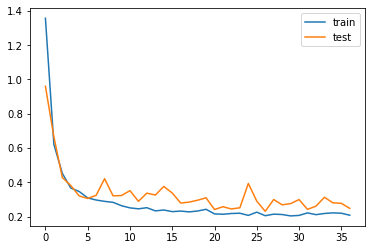

In [12]:
from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Save or Loading the best model

In [16]:
model.save('speech2text_model.hdf5')

In [17]:
from keras.models import load_model
model = load_model('speech2text_model.hdf5')

Define the function that predicts text for the given audio:

In [18]:
def s2t_predict(audio, shape_num=8000):
    prob=model.predict(audio.reshape(1,shape_num,1))
    index=np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data:

In [19]:
import random
index=random.randint(0,len(x_valid)-1)
samples=x_valid[index].ravel()
print("Audio:",classes[np.argmax(y_valid[index])])
ipd.Audio(samples, rate=8000)

Audio: down


In [20]:
samples.shape

(8000,)

In [21]:
print("Text:",s2t_predict(samples))

Text: down


The best part is yet to come! Here is a script that prompts a user to record voice commands. Record your own voice commands and test it on the model:

Let us now read the saved voice command and convert it to text:

In [47]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [48]:
#reading the voice commands
test, test_rate = librosa.load('yes.wav', sr = 16000)
test_sample = librosa.resample(test, test_rate, 8000)
print(test_sample.shape)
ipd.Audio(test_sample,rate=8000)              

(8000,)


In [49]:
#converting voice commands to text
s2t_predict(test_sample)

'yes'